# Q5: Deeper CNN Training on SVHN 
Train a controlled deep convolutional neural network (CNN) on a subset of the SVHN
dataset. Set random seeds to 42. Load and preprocess SVHN. Build the network using
the following configuration:
- Load SVHN and normalize pixel values to [0,1]
- Use only the first 2000 training samples and first 500 test samples
- Input shape: 32 × 32 × 3
- CNN architecture:
- Conv2D: 32 filters, 3×3 kernel, ReLU activation
- Conv2D: 32 filters, 3×3 kernel, ReLU activation
- MaxPooling2D: 2×2
- Conv2D: 64 filters, 3×3 kernel, ReLU activation
- Conv2D: 64 filters, 3×3 kernel, ReLU activation
- MaxPooling2D: 2×2
- Flatten
- Dense: 256 neurons, ReLU activation
- Dropout: 0.3
- Output layer: 10 neurons with softmax
- Optimizer: Adam, learning rate = 0.001
- Loss: sparse categorical crossentropy
- epochs = 15, batch size = 32


Q5.1 Report the test accuracy of the deeper CNN model.

# Imports and seeding 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

New dataset, time to look at what were dealing with

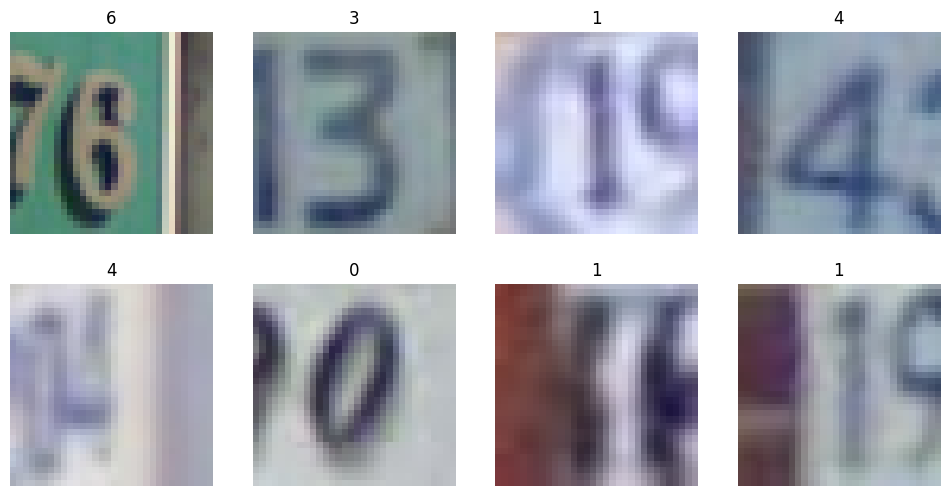

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

# Load SVHN training set
svhn_full = datasets.SVHN('./data', split='train', download=True, transform=transforms.Compose([transforms.ToTensor()]))
svhn_subset = Subset(svhn_full, range(1000))

indices = torch.randperm(len(svhn_subset))[:8]
images, labels = torch.stack([svhn_subset[i][0] for i in indices]), torch.tensor([svhn_subset[i][1] for i in indices])

# Plot
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    # SVHN images are 3-channel, so permute to HxWxC for matplotlib
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(labels[i].item())
    plt.axis('off')
plt.show()


The SVHN (aka The Street View House Numbers) dataset is exactly what it says it is, a dataset of real world house numbers. The version of the dataset that we will be using is the one that is more MNIST-like with 32x32 images centred around a single digit. In some images there are multiple numbers included in frame the label will match the one cencentralized


![SVNH](SVHN-example.PNG)

Image from [Stanford University's CS department](http://ufldl.stanford.edu/housenumbers/)

# Load data

In [3]:

tfm = transforms.Compose([transforms.ToTensor()])  # ToTensor gives [0,1]
train_full = datasets.SVHN(root='./data', split='train', download=True, transform=tfm)
test_full  = datasets.SVHN(root='./data', split='test',  download=True, transform=tfm)

train_ds = Subset(train_full, range(2000))
test_ds  = Subset(test_full,  range(500))

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# Model definiton 

In [4]:

# Model 
class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),  # input size 32x32 -> two poolings -> 8x8
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model = DeeperCNN().to(device)

# Optimizer & loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
epochs = 15
for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device).long()
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running += loss.item()
    print(f"Epoch {epoch}/{epochs} - Train loss: {running/len(train_dl):.4f}")

# Evaluation on test subset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device).long()
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

test_acc = 100 * correct / total
print(f"\nTest Accuracy: {test_acc:.2f}%")


Epoch 1/15 - Train loss: 2.2443
Epoch 2/15 - Train loss: 2.2341
Epoch 3/15 - Train loss: 2.2315
Epoch 4/15 - Train loss: 2.2292
Epoch 5/15 - Train loss: 2.2308
Epoch 6/15 - Train loss: 2.2313
Epoch 7/15 - Train loss: 2.2312
Epoch 8/15 - Train loss: 2.2070
Epoch 9/15 - Train loss: 2.1999
Epoch 10/15 - Train loss: 2.0772
Epoch 11/15 - Train loss: 1.7319
Epoch 12/15 - Train loss: 1.2910
Epoch 13/15 - Train loss: 0.9621
Epoch 14/15 - Train loss: 0.7438
Epoch 15/15 - Train loss: 0.5716

Test Accuracy: 76.80%
